# League of Legends Meta Analysis - Machine Learning

## Projet d'analyse de la méta et prédiction de victoire

**Objectif** : Maximiser les chances de victoire dans League of Legends en s'appuyant sur l'analyse des données et des modèles de machine learning.

**Approche** : 
- Analyser la méta actuelle (champions, items)
- Optimiser les builds et performances
- Développer des stratégies de draft (picks/bans)
- Prédire l'issue des parties

---

Ce notebook suit le plan d'action détaillé et implémente chaque phase progressivement.

# Phase 0 — Préparation et Qualité des Données

## Objectifs de cette phase :
1. **Rassembler et contrôler** : Charger tous les fichiers CSV du dataset
2. **Nettoyer** : Gérer les IDs anormaux, valeurs manquantes, données corrompues
3. **Échantillonner** : Conserver uniquement les modes **CLASSIC** et **ARAM** (exclure les autres)
4. **Définir les jeux** : Pour chaque patch, créer un split 80% train / 20% test 

**Pourquoi cette phase est cruciale ?**
- La qualité des données impacte directement la fiabilité des modèles
- Un nettoyage rigoureux évite les biais et erreurs de prédiction
- Une séparation par patch évite le "data leakage" et garantit que notre modèle peut généraliser sur des données futures, patch par patch

## 0.1 - Import des bibliothèques

**Bibliothèques nécessaires :**
- **pandas** : Manipulation et analyse de données tabulaires
- **numpy** : Calculs numériques et opérations sur tableaux
- **matplotlib/seaborn** : Visualisations statistiques
- **sklearn** : Préparation des données et modélisation ML

In [29]:
# Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliothèques importées avec succès!")
print(f"Version pandas: {pd.__version__}")
print(f"Version numpy: {np.__version__}")

Bibliothèques importées avec succès!
Version pandas: 2.3.3
Version numpy: 2.4.0


## 0.2 - Chargement des données

**Structure du dataset :**
- **ChampionTbl.csv** : Table de référence des champions (175 champions)
- **ItemTbl.csv** : Table de référence des items (637 objets)
- **RankTbl.csv** : Table de référence des rangs (11 niveaux)
- **MatchTbl.csv** : Table des matchs (110,479 matchs)
- **SummonerMatchTbl.csv** : Association joueur-match-champion (223,154 enregistrements)
- **MatchStatsTbl.csv** : Statistiques détaillées par joueur (223,154 enregistrements)
- **TeamMatchTbl.csv** : Statistiques par équipe (97,885 enregistrements)

**Pourquoi charger toutes les tables ?**
Ces tables sont reliées entre elles (base de données relationnelle). Nous aurons besoin de faire des jointures pour enrichir nos analyses et créer des features pertinentes pour nos modèles.

In [30]:
# Définir le chemin vers le dataset
dataset_path = Path("../Dataset")

# Charger toutes les tables
print("🔄 Chargement des tables...")

# Tables de référence (lookup tables)
champions_df = pd.read_csv(dataset_path / "ChampionTbl.csv")
items_df = pd.read_csv(dataset_path / "ItemTbl.csv")
ranks_df = pd.read_csv(dataset_path / "RankTbl.csv")

# Tables de faits (fact tables)
matches_df = pd.read_csv(dataset_path / "MatchTbl.csv")
summoner_match_df = pd.read_csv(dataset_path / "SummonerMatchTbl.csv")
match_stats_df = pd.read_csv(dataset_path / "MatchStatsTbl.csv")
team_match_df = pd.read_csv(dataset_path / "TeamMatchTbl.csv")

print("✅ Toutes les tables chargées!\n")

# Filtrer pour ne garder que les modes CLASSIC et ARAM
print("🎮 Filtrage des modes de jeu: conservation de CLASSIC et ARAM uniquement")
allowed_modes = ["CLASSIC", "ARAM"]
matches_df = matches_df[matches_df["QueueType"].isin(allowed_modes)].copy()

# Construire le set des MatchIds conservés et cascade sur les autres tables
allowed_match_ids = set(matches_df["MatchId"].values)

def filter_by_match_ids(df):
    if "MatchFk" in df.columns:
        return df[df["MatchFk"].isin(allowed_match_ids)].copy()
    elif "MatchId" in df.columns:
        return df[df["MatchId"].isin(allowed_match_ids)].copy()
    else:
        return df

summoner_match_df = filter_by_match_ids(summoner_match_df)
match_stats_df = filter_by_match_ids(match_stats_df)
team_match_df = filter_by_match_ids(team_match_df)

print(f"   MatchTbl conservé: {len(matches_df):,} lignes")
print(f"   SummonerMatchTbl conservé: {len(summoner_match_df):,} lignes")
print(f"   MatchStatsTbl conservé: {len(match_stats_df):,} lignes")
print(f"   TeamMatchTbl conservé: {len(team_match_df):,} lignes\n")

# Afficher les dimensions
tables = {
    "Champions": champions_df,
    "Items": items_df,
    "Ranks": ranks_df,
    "Matches": matches_df,
    "SummonerMatch": summoner_match_df,
    "MatchStats": match_stats_df,
    "TeamMatch": team_match_df
}

print("📊 Dimensions des tables:")
print("-" * 50)
for name, df in tables.items():
    print(f"{name:20} : {df.shape[0]:>8} lignes × {df.shape[1]:>2} colonnes")
    
print(f"\n💾 Mémoire totale utilisée: {sum(df.memory_usage(deep=True).sum() for df in tables.values()) / 1024**2:.2f} MB")

🔄 Chargement des tables...
✅ Toutes les tables chargées!

🎮 Filtrage des modes de jeu: conservation de CLASSIC et ARAM uniquement
   MatchTbl conservé: 129,543 lignes
   SummonerMatchTbl conservé: 262,756 lignes
   MatchStatsTbl conservé: 303,512 lignes
   TeamMatchTbl conservé: 116,686 lignes

📊 Dimensions des tables:
--------------------------------------------------
Champions            :      173 lignes ×  3 colonnes
Items                :      635 lignes ×  2 colonnes
Ranks                :       11 lignes ×  2 colonnes
Matches              :   129543 lignes ×  5 colonnes
SummonerMatch        :   262756 lignes ×  4 colonnes
MatchStats           :   303512 lignes × 31 colonnes
TeamMatch            :   116686 lignes × 24 colonnes

💾 Mémoire totale utilisée: 163.04 MB


## 0.3 - Exploration initiale des données

**Objectif :** Comprendre la structure, les types de données et détecter les premières anomalies.

**Ce que nous allons vérifier :**
- Types de données de chaque colonne
- Valeurs manquantes (NaN)
- Valeurs uniques et distribution
- Cohérence des clés étrangères

In [31]:
# Fonction helper pour explorer une table
def explore_table(df, name):
    print(f"\n{'='*60}")
    print(f"📋 TABLE: {name}")
    print('='*60)
    
    # Aperçu
    print("\n🔍 Aperçu des premières lignes:")
    display(df.head(5))
    
    # Informations sur les colonnes
    print(f"\n📊 Informations sur les colonnes:")
    print(df.info())
    
    # Valeurs manquantes
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️  Valeurs manquantes détectées:")
        print(missing[missing > 0])
    else:
        print(f"\n✅ Aucune valeur manquante détectée")
    
    return df

# Explorer les tables de référence (plus petites)
print("="*60)
print("🔎 EXPLORATION DES TABLES DE RÉFÉRENCE")
print("="*60)

explore_table(champions_df, "ChampionTbl")
explore_table(items_df, "ItemTbl") 
explore_table(ranks_df, "RankTbl")

🔎 EXPLORATION DES TABLES DE RÉFÉRENCE

📋 TABLE: ChampionTbl

🔍 Aperçu des premières lignes:


,ChampionId,ChampionName,ChampionLane
0,0,No Champion,NONE
1,1,Annie,MID
2,2,Olaf,JUNGLE
3,3,Galio,MID
4,4,TwistedFate,MID



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ChampionId    173 non-null    int64 
 1   ChampionName  173 non-null    object
 2   ChampionLane  173 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.2+ KB
None

✅ Aucune valeur manquante détectée

📋 TABLE: ItemTbl

🔍 Aperçu des premières lignes:


,ItemID,ItemName
0,1001,Boots
1,1004,Faerie Charm
2,1006,Rejuvenation Bead
3,1011,Giant's Belt
4,1018,Cloak of Agility



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ItemID    635 non-null    int64 
 1   ItemName  635 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB
None

✅ Aucune valeur manquante détectée

📋 TABLE: RankTbl

🔍 Aperçu des premières lignes:


,RankId,RankName
0,0,Unranked
1,1,Iron
2,2,Bronze
3,3,Silver
4,4,Gold



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RankId    11 non-null     int64 
 1   RankName  11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes
None

✅ Aucune valeur manquante détectée


,RankId,RankName
0,0,Unranked
1,1,Iron
2,2,Bronze
3,3,Silver
4,4,Gold
5,5,Platinum
6,6,Emerald
7,7,Diamond
8,8,Master
9,9,Grandmaster


In [32]:
# Explorer MatchTbl (table centrale)
print("\n" + "="*60)
print("🔎 EXPLORATION DE LA TABLE CENTRALE DES MATCHS")
print("="*60)

explore_table(matches_df, "MatchTbl")

# Analyses spécifiques pour MatchTbl
print("\n📊 Analyses complémentaires pour MatchTbl:")
print("-" * 60)

# Distribution des types de queue
print("\n🎮 Distribution des modes de jeu:")
print(matches_df['QueueType'].value_counts())

# Distribution des ranks
print("\n🏆 Distribution des ranks:")
rank_dist = matches_df['RankFk'].value_counts().sort_index()
print(rank_dist)

# Statistiques sur les patches
print("\n🔧 Statistiques sur les patches:")
print(f"Nombre de patches différents: {matches_df['Patch'].nunique()}")
print("\nTop 10 patches les plus fréquents:")
print(matches_df['Patch'].value_counts().head(10))

# Durée des matchs
print("\n⏱️  Statistiques sur la durée des matchs:")
print(f"Durée min: {matches_df['GameDuration'].min()} sec ({matches_df['GameDuration'].min()/60:.1f} min)")
print(f"Durée max: {matches_df['GameDuration'].max()} sec ({matches_df['GameDuration'].max()/60:.1f} min)")
print(f"Durée moyenne: {matches_df['GameDuration'].mean():.0f} sec ({matches_df['GameDuration'].mean()/60:.1f} min)")
print(f"Durée médiane: {matches_df['GameDuration'].median():.0f} sec ({matches_df['GameDuration'].median()/60:.1f} min)")


🔎 EXPLORATION DE LA TABLE CENTRALE DES MATCHS

📋 TABLE: MatchTbl

🔍 Aperçu des premières lignes:


,MatchId,Patch,QueueType,RankFk,GameDuration
0,EUN1_3707659547,14.23.636.9832,ARAM,0,1173
1,EUN1_3709211408,14.24.642.1879,CLASSIC,0,1986
2,EUN1_3710823249,14.24.643.5128,ARAM,0,813
3,EUN1_3710849604,14.24.643.5128,ARAM,0,1070
4,EUN1_3710885279,14.24.643.5128,ARAM,0,968



📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
Index: 129543 entries, 0 to 149862
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   MatchId       129543 non-null  object
 1   Patch         129543 non-null  object
 2   QueueType     129543 non-null  object
 3   RankFk        129543 non-null  int64 
 4   GameDuration  129543 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 5.9+ MB
None

✅ Aucune valeur manquante détectée

📊 Analyses complémentaires pour MatchTbl:
------------------------------------------------------------

🎮 Distribution des modes de jeu:
QueueType
CLASSIC    113280
ARAM        16263
Name: count, dtype: int64

🏆 Distribution des ranks:
RankFk
0     12372
1      1907
2      3756
3     10383
4     17581
5     19037
6     15382
7     16415
8     30029
9      2256
10      425
Name: count, dtype: int64

🔧 Statistiques sur les patches:
Nombre de patches différents: 119


In [33]:
# Explorer MatchStatsTbl (statistiques détaillées)
print("\n" + "="*60)
print("🔎 EXPLORATION DES STATISTIQUES DE MATCH")
print("="*60)

print(f"\n📋 Aperçu de MatchStatsTbl:")
print(f"Dimensions: {match_stats_df.shape[0]} lignes × {match_stats_df.shape[1]} colonnes")
display(match_stats_df.head(3))

print(f"\n📊 Info sur les colonnes:")
match_stats_df.info()

# Vérifier les valeurs manquantes
missing_stats = match_stats_df.isnull().sum()
if missing_stats.sum() > 0:
    print(f"\n⚠️  Valeurs manquantes:")
    print(missing_stats[missing_stats > 0])
else:
    print(f"\n✅ Aucune valeur manquante détectée")

# Statistiques sur les performances
print(f"\n📈 Statistiques de performance clés:")
key_metrics = ['MinionsKilled', 'TotalGold', 'DmgDealt', 'DmgTaken', 'kills', 'deaths', 'assists', 'visionScore']
display(match_stats_df[key_metrics].describe())


🔎 EXPLORATION DES STATISTIQUES DE MATCH

📋 Aperçu de MatchStatsTbl:
Dimensions: 303512 lignes × 31 colonnes


,MatchStatsId,SummonerMatchFk,MinionsKilled,DmgDealt,DmgTaken,TurretDmgDealt,TotalGold,Lane,Win,item1,item2,item3,item4,item5,item6,kills,deaths,assists,PrimaryKeyStone,PrimarySlot1,PrimarySlot2,PrimarySlot3,SecondarySlot1,SecondarySlot2,SummonerSpell1,SummonerSpell2,CurrentMasteryPoints,EnemyChampionFk,DragonKills,BaronKills,visionScore
0,1,1,30,4765,12541,0,7058,BOTTOM,0,3870,2055,3107,3171,6620,2022,0,2,12,8465,8463,8473,8453,8345,8347,4,7,902,51,0,0,67
1,2,2,29,8821,14534,1,9618,BOTTOM,0,3870,2065,3107,3158,6620,3916,2,5,23,8465,8463,8473,8453,8345,8347,4,7,902,236,0,0,88
2,3,3,34,6410,19011,3,9877,BOTTOM,1,3870,3107,1011,3171,6617,3916,0,5,22,8214,8226,8210,8237,8345,8347,4,7,16,498,0,0,97



📊 Info sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303512 entries, 0 to 303511
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   MatchStatsId          303512 non-null  int64 
 1   SummonerMatchFk       303512 non-null  int64 
 2   MinionsKilled         303512 non-null  int64 
 3   DmgDealt              303512 non-null  int64 
 4   DmgTaken              303512 non-null  int64 
 5   TurretDmgDealt        303512 non-null  int64 
 6   TotalGold             303512 non-null  int64 
 7   Lane                  303512 non-null  object
 8   Win                   303512 non-null  int64 
 9   item1                 303512 non-null  int64 
 10  item2                 303512 non-null  int64 
 11  item3                 303512 non-null  int64 
 12  item4                 303512 non-null  int64 
 13  item5                 303512 non-null  int64 
 14  item6                 303512 non-null  int

,MinionsKilled,TotalGold,DmgDealt,DmgTaken,kills,deaths,assists,visionScore
count,303512.000000,303512.000000,303512.000000,303512.000000,303512.000000,303512.00000,303512.000000,303512.000000
mean,109.825358,12150.009285,24737.295787,29521.976703,6.680464,6.44814,9.649365,19.901862
std,89.620708,4539.919226,17014.079206,17550.532523,5.336263,3.69644,8.658234,22.064867
min,0.000000,500.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,25.000000,9185.000000,12999.000000,18358.000000,3.000000,4.00000,4.000000,5.000000
50%,102.000000,11847.000000,21309.000000,26392.000000,6.000000,6.00000,7.000000,15.000000
75%,187.000000,14795.000000,32151.000000,37011.250000,9.000000,9.00000,13.000000,25.000000
max,549.000000,56281.000000,314904.000000,435808.000000,54.000000,46.00000,92.000000,220.000000


## 0.4 - Détection et nettoyage des anomalies

**Anomalies possibles :**
1. **IDs de champions anormaux** : Certains ChampionIds très élevés (>200,000) ne correspondent pas à ChampionTbl
2. **IDs d'items invalides** : Certains ItemIds ne correspondent pas à ItemTbl  
3. **Runes à 0** : PrimaryKeyStone=0 est impossible en réalité (données manquantes)
4. **Sorts d'invocateur à 0** : Invalide en jeu normal

**Plan de nettoyage :**
- Identifier les IDs invalides en croisant avec les tables de référence
- Décider de la stratégie : suppression ou imputation selon le % d'anomalies
- Créer une version "clean" du dataset pour les analyses

In [34]:
# Créer des sets de valeurs valides
valid_champion_ids = set(champions_df['ChampionId'].values)
valid_item_ids = set(items_df['ItemID'].values)
valid_match_ids = set(matches_df['MatchId'].values)

print("🔍 Détection des anomalies...")
print("=" * 60)

# 1. Vérifier les ChampionIds dans SummonerMatchTbl
print("\n1️⃣ Vérification des ChampionIds dans SummonerMatchTbl:")
invalid_champions_sm = summoner_match_df[~summoner_match_df['ChampionFk'].isin(valid_champion_ids)]
print(f"   Enregistrements avec ChampionId invalide: {len(invalid_champions_sm)} ({len(invalid_champions_sm)/len(summoner_match_df)*100:.2f}%)")
if len(invalid_champions_sm) > 0:
    print(f"   Champions invalides uniques: {invalid_champions_sm['ChampionFk'].nunique()}")
    print(f"   Exemples: {invalid_champions_sm['ChampionFk'].unique()[:10]}")

# 2. Vérifier les ChampionIds dans MatchStatsTbl (EnemyChampionFk)
print("\n2️⃣ Vérification des EnemyChampionFk dans MatchStatsTbl:")
invalid_enemy_champs = match_stats_df[~match_stats_df['EnemyChampionFk'].isin(valid_champion_ids)]
print(f"   Enregistrements avec EnemyChampionFk invalide: {len(invalid_enemy_champs)} ({len(invalid_enemy_champs)/len(match_stats_df)*100:.2f}%)")

# 3. Vérifier les Items dans MatchStatsTbl
print("\n3️⃣ Vérification des Items dans MatchStatsTbl:")
item_cols = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6']
invalid_items_count = 0
for col in item_cols:
    # Filtrer les 0 (slots vides) qui sont valides
    non_zero_items = match_stats_df[match_stats_df[col] != 0]
    invalid = non_zero_items[~non_zero_items[col].isin(valid_item_ids)]
    invalid_items_count += len(invalid)
    if len(invalid) > 0:
        print(f"   {col}: {len(invalid)} items invalides ({len(invalid)/len(non_zero_items)*100:.2f}%)")

print(f"   Total d'items invalides (non-zéro): {invalid_items_count}")

# 4. Vérifier les runes à 0
print("\n4️⃣ Vérification des runes (PrimaryKeyStone):")
zero_runes = match_stats_df[match_stats_df['PrimaryKeyStone'] == 0]
print(f"   Enregistrements avec PrimaryKeyStone=0: {len(zero_runes)} ({len(zero_runes)/len(match_stats_df)*100:.2f}%)")

# 5. Vérifier les sorts d'invocateur à 0
print("\n5️⃣ Vérification des sorts d'invocateur:")
zero_spell1 = match_stats_df[match_stats_df['SummonerSpell1'] == 0]
zero_spell2 = match_stats_df[match_stats_df['SummonerSpell2'] == 0]
print(f"   SummonerSpell1=0: {len(zero_spell1)} ({len(zero_spell1)/len(match_stats_df)*100:.2f}%)")
print(f"   SummonerSpell2=0: {len(zero_spell2)} ({len(zero_spell2)/len(match_stats_df)*100:.2f}%)")

# 6. Vérifier les champions dans TeamMatchTbl
print("\n6️⃣ Vérification des compositions dans TeamMatchTbl:")
team_champ_cols = ['B1Champ', 'B2Champ', 'B3Champ', 'B4Champ', 'B5Champ', 
                   'R1Champ', 'R2Champ', 'R3Champ', 'R4Champ', 'R5Champ']
invalid_team_champs = 0
for col in team_champ_cols:
    invalid = team_match_df[~team_match_df[col].isin(valid_champion_ids)]
    invalid_team_champs += len(invalid)
    if len(invalid) > 0:
        print(f"   {col}: {len(invalid)} champions invalides")

print(f"   Total de champions invalides dans les compositions: {invalid_team_champs}")

🔍 Détection des anomalies...

1️⃣ Vérification des ChampionIds dans SummonerMatchTbl:
   Enregistrements avec ChampionId invalide: 0 (0.00%)

2️⃣ Vérification des EnemyChampionFk dans MatchStatsTbl:
   Enregistrements avec EnemyChampionFk invalide: 0 (0.00%)

3️⃣ Vérification des Items dans MatchStatsTbl:
   item5: 2 items invalides (0.00%)
   Total d'items invalides (non-zéro): 2

4️⃣ Vérification des runes (PrimaryKeyStone):
   Enregistrements avec PrimaryKeyStone=0: 33764 (11.12%)

5️⃣ Vérification des sorts d'invocateur:
   SummonerSpell1=0: 0 (0.00%)
   SummonerSpell2=0: 0 (0.00%)

6️⃣ Vérification des compositions dans TeamMatchTbl:
   Total de champions invalides dans les compositions: 0


In [35]:
# Application du nettoyage
print("\n🧹 Application du nettoyage des données...")
print("=" * 60)

# Copier les dataframes pour garder les originaux
summoner_match_clean = summoner_match_df.copy()
match_stats_clean = match_stats_df.copy()
team_match_clean = team_match_df.copy()

# Compteurs de nettoyage
cleaning_summary = {
    'summoner_match_removed': 0,
    'match_stats_removed': 0,
    'team_match_removed': 0,
    'runes_to_nan': 0,
    'spells_to_nan': 0,
    'items_to_nan': 0
}

# 1. Nettoyer SummonerMatchTbl - Supprimer les champions invalides
print("\n1️⃣ Nettoyage de SummonerMatchTbl:")
before = len(summoner_match_clean)
summoner_match_clean = summoner_match_clean[summoner_match_clean['ChampionFk'].isin(valid_champion_ids)]
cleaning_summary['summoner_match_removed'] = before - len(summoner_match_clean)
print(f"   ✅ {cleaning_summary['summoner_match_removed']} enregistrements supprimés ({cleaning_summary['summoner_match_removed']/before*100:.2f}%)")

# 2. Nettoyer MatchStatsTbl - Runes à 0 → NaN
print("\n2️⃣ Nettoyage des runes dans MatchStatsTbl:")
rune_cols = ['PrimaryKeyStone', 'PrimarySlot1', 'PrimarySlot2', 'PrimarySlot3', 'SecondarySlot1', 'SecondarySlot2']
for col in rune_cols:
    count = (match_stats_clean[col] == 0).sum()
    match_stats_clean.loc[match_stats_clean[col] == 0, col] = np.nan
    cleaning_summary['runes_to_nan'] += count
print(f"   ✅ {cleaning_summary['runes_to_nan']} valeurs de runes converties en NaN")

# 3. Nettoyer MatchStatsTbl - Sorts d'invocateur à 0 → NaN
print("\n3️⃣ Nettoyage des sorts d'invocateur dans MatchStatsTbl:")
spell_cols = ['SummonerSpell1', 'SummonerSpell2']
for col in spell_cols:
    count = (match_stats_clean[col] == 0).sum()
    match_stats_clean.loc[match_stats_clean[col] == 0, col] = np.nan
    cleaning_summary['spells_to_nan'] += count
print(f"   ✅ {cleaning_summary['spells_to_nan']} valeurs de sorts converties en NaN")

# 4. Nettoyer les items invalides (non-zéro et non-valides) → NaN
print("\n4️⃣ Nettoyage des items invalides dans MatchStatsTbl:")
for col in item_cols:
    # Identifier les items invalides (non-zéro ET non dans la liste valide)
    invalid_mask = (match_stats_clean[col] != 0) & (~match_stats_clean[col].isin(valid_item_ids))
    count = invalid_mask.sum()
    match_stats_clean.loc[invalid_mask, col] = np.nan
    cleaning_summary['items_to_nan'] += count
print(f"   ✅ {cleaning_summary['items_to_nan']} items invalides convertis en NaN")

# 5. Nettoyer TeamMatchTbl - Supprimer les lignes avec champions invalides
print("\n5️⃣ Nettoyage de TeamMatchTbl:")
before = len(team_match_clean)
valid_mask = True
for col in team_champ_cols:
    valid_mask &= team_match_clean[col].isin(valid_champion_ids)
team_match_clean = team_match_clean[valid_mask]
cleaning_summary['team_match_removed'] = before - len(team_match_clean)
print(f"   ✅ {cleaning_summary['team_match_removed']} enregistrements supprimés ({cleaning_summary['team_match_removed']/before*100:.2f}%)")

# Résumé final
print("\n" + "=" * 60)
print("📊 RÉSUMÉ DU NETTOYAGE")
print("=" * 60)

print(
    f"\nSummonerMatchTbl: {len(summoner_match_df):,} → "
    f"{len(summoner_match_clean):,} "
    f"(-{cleaning_summary['summoner_match_removed']:,})"
)

print(f"MatchStatsTbl: {len(match_stats_df):,} lignes conservées")
print(f"  - Runes converties en NaN: {cleaning_summary['runes_to_nan']:,}")
print(f"  - Sorts convertis en NaN: {cleaning_summary['spells_to_nan']:,}")
print(f"  - Items convertis en NaN: {cleaning_summary['items_to_nan']:,}")

print(
    f"TeamMatchTbl: {len(team_match_df):,} → "
    f"{len(team_match_clean):,} "
    f"(-{cleaning_summary['team_match_removed']:,})"
)

print("\n✅ Nettoyage terminé! Les dataframes '_clean' sont prêts pour l'analyse.")


🧹 Application du nettoyage des données...

1️⃣ Nettoyage de SummonerMatchTbl:
   ✅ 0 enregistrements supprimés (0.00%)

2️⃣ Nettoyage des runes dans MatchStatsTbl:
   ✅ 202584 valeurs de runes converties en NaN

3️⃣ Nettoyage des sorts d'invocateur dans MatchStatsTbl:
   ✅ 0 valeurs de sorts converties en NaN

4️⃣ Nettoyage des items invalides dans MatchStatsTbl:
   ✅ 2 items invalides convertis en NaN

5️⃣ Nettoyage de TeamMatchTbl:
   ✅ 0 enregistrements supprimés (0.00%)

📊 RÉSUMÉ DU NETTOYAGE

SummonerMatchTbl: 262,756 → 262,756 (-0)
MatchStatsTbl: 303,512 lignes conservées
  - Runes converties en NaN: 202,584
  - Sorts convertis en NaN: 0
  - Items convertis en NaN: 2
TeamMatchTbl: 116,686 → 116,686 (-0)

✅ Nettoyage terminé! Les dataframes '_clean' sont prêts pour l'analyse.


## 0.5 - Échantillonnage et segmentation

**Objectif :** Séparer les données selon différents critères pour des analyses ciblées.

**Segmentations importantes :**
1. **Par mode de jeu** : uniquement **ARAM** et **CLASSIC** (autres modes exclus)
2. **Par niveau de compétition** : Ranked (RankFk > 0) vs Unranked (RankFk = 0)
3. **Par patch** : Séparer les patches pour analyse temporelle

**Pourquoi c'est important ?**
- ARAM et CLASSIC ont des règles différentes → méta différente
- Les ranked games sont plus compétitives et représentatives
- L'analyse par patch permet de détecter l'évolution de la méta

In [36]:
# Créer les différentes segmentations
print("🎯 Création des segmentations du dataset...")
print("=" * 60)

# 1. Segmentation par mode de jeu
print("\n1️⃣ Segmentation par mode de jeu:")
aram_matches = matches_df[matches_df['QueueType'] == 'ARAM']
classic_matches = matches_df[matches_df['QueueType'] == 'CLASSIC']

print(f"   ARAM: {len(aram_matches):,} matchs ({len(aram_matches)/len(matches_df)*100:.1f}%)")
print(f"   CLASSIC: {len(classic_matches):,} matchs ({len(classic_matches)/len(matches_df)*100:.1f}%)")

# 2. Segmentation par niveau de compétition
print("\n2️⃣ Segmentation par niveau de compétition:")
unranked_matches = matches_df[matches_df['RankFk'] == 0]
ranked_matches = matches_df[matches_df['RankFk'] > 0]

print(f"   Unranked: {len(unranked_matches):,} matchs ({len(unranked_matches)/len(matches_df)*100:.1f}%)")
print(f"   Ranked: {len(ranked_matches):,} matchs ({len(ranked_matches)/len(matches_df)*100:.1f}%)")

# Distribution des ranks pour les ranked games
if len(ranked_matches) > 0:
    print("\n   📊 Distribution des ranks (pour ranked games):")
    rank_distribution = ranked_matches['RankFk'].value_counts().sort_index()
    for rank_id, count in rank_distribution.items():
        rank_name = ranks_df[ranks_df['RankId'] == rank_id]['RankName'].values[0] if rank_id in ranks_df['RankId'].values else 'Unknown'
        print(f"      {rank_name:15} (ID={rank_id}): {count:,} matchs ({count/len(ranked_matches)*100:.1f}%)")

# 3. Extraction de la version majeure du patch (ex: 14.23.636.9832 → 14.23)
print("\n3️⃣ Analyse des patches:")
matches_df['PatchMajor'] = matches_df['Patch'].str.split('.').str[:2].str.join('.')
patch_distribution = matches_df['PatchMajor'].value_counts().sort_index()

print(f"   Nombre de patches majeurs: {matches_df['PatchMajor'].nunique()}")
print(f"\n   Top 10 patches majeurs:")
for patch, count in patch_distribution.head(10).items():
    print(f"      Patch {patch}: {count:,} matchs ({count/len(matches_df)*100:.1f}%)")

# 4. Catégorisation par durée de partie
print("\n4️⃣ Catégorisation par durée de partie:")
matches_df['DurationCategory'] = pd.cut(
    matches_df['GameDuration'] / 60,  # Convertir en minutes
    bins=[0, 20, 30, float('inf')],
    labels=['Courte (<20min)', 'Standard (20-30min)', 'Longue (>30min)']
)

duration_dist = matches_df['DurationCategory'].value_counts()
for category, count in duration_dist.items():
    print(f"   {category}: {count:,} matchs ({count/len(matches_df)*100:.1f}%)")

print("\n✅ Segmentations créées avec succès!")

🎯 Création des segmentations du dataset...

1️⃣ Segmentation par mode de jeu:
   ARAM: 16,263 matchs (12.6%)
   CLASSIC: 113,280 matchs (87.4%)

2️⃣ Segmentation par niveau de compétition:
   Unranked: 12,372 matchs (9.6%)
   Ranked: 117,171 matchs (90.4%)

   📊 Distribution des ranks (pour ranked games):
      Iron            (ID=1): 1,907 matchs (1.6%)
      Bronze          (ID=2): 3,756 matchs (3.2%)
      Silver          (ID=3): 10,383 matchs (8.9%)
      Gold            (ID=4): 17,581 matchs (15.0%)
      Platinum        (ID=5): 19,037 matchs (16.2%)
      Emerald         (ID=6): 15,382 matchs (13.1%)
      Diamond         (ID=7): 16,415 matchs (14.0%)
      Master          (ID=8): 30,029 matchs (25.6%)
      Grandmaster     (ID=9): 2,256 matchs (1.9%)
      Challenger      (ID=10): 425 matchs (0.4%)

3️⃣ Analyse des patches:
   Nombre de patches majeurs: 50

   Top 10 patches majeurs:
      Patch 13.22: 5 matchs (0.0%)
      Patch 13.23: 8 matchs (0.0%)
      Patch 13.24: 4 match

## 0.6 - Création des ensembles Train/Test par patch

**Stratégie de split par patch :**
- **Pourquoi par patch ?** La méta change à chaque version. On veut évaluer et entraîner sur chaque patch séparément.
- **Split par patch** : Pour chaque patch, 80% des matchs vont dans le train, 20% restants dans le test.
- **Objectif** : Disposer d'une méta par patch et éviter le leakage entre versions.

In [37]:
# Créer les ensembles train/test par patch (80/20)
print("📊 Création des ensembles Train/Test par patch (80/20)...")
print("=" * 60)

# Vérifier la colonne PatchMajor (crée si absente)
if 'PatchMajor' not in matches_df.columns:
    matches_df['PatchMajor'] = matches_df['Patch'].str.split('.').str[:2].str.join('.')

# Split 80/20 au sein de chaque patch (aléatoire mais reproductible)
train_ids = []
test_ids = []
per_patch_stats = []

for patch, group in matches_df.groupby('PatchMajor'):
    if len(group) == 1:
        train_group = group
        test_group = group.iloc[0:0]
    else:
        train_group = group.sample(frac=0.8, random_state=42)
        test_group = group.drop(train_group.index)
    
    train_ids.extend(train_group['MatchId'].tolist())
    test_ids.extend(test_group['MatchId'].tolist())
    per_patch_stats.append({
        'PatchMajor': patch,
        'train_count': len(train_group),
        'test_count': len(test_group),
        'total': len(group)
    })

# Construire les ensembles
train_matches = matches_df[matches_df['MatchId'].isin(train_ids)]
test_matches = matches_df[matches_df['MatchId'].isin(test_ids)]

# Résumé global
print(f"\nNombre de patches: {len(per_patch_stats)}")
print(f"Total matchs: {len(matches_df):,}")
print(f"TRAIN total: {len(train_matches):,} ({len(train_matches)/len(matches_df)*100:.1f}%)")
print(f"TEST total:  {len(test_matches):,} ({len(test_matches)/len(matches_df)*100:.1f}%)")

# Afficher un aperçu des splits par patch (top 10 par ordre)
split_overview = pd.DataFrame(per_patch_stats).sort_values('PatchMajor')
print("\nAperçu des splits par patch (top 10):")
print(split_overview.head(10))

# Créer des sets de MatchIds pour filtrer les autres tables
train_match_ids = set(train_ids)
test_match_ids = set(test_ids)

print("\n✅ Ensembles train/test créés par patch (80/20) avec succès!")
print("💡 Note: utilisez train_match_ids et test_match_ids pour filtrer MatchStats, TeamMatch, etc.")

📊 Création des ensembles Train/Test par patch (80/20)...

Nombre de patches: 50
Total matchs: 129,543
TRAIN total: 103,636 (80.0%)
TEST total:  25,907 (20.0%)

Aperçu des splits par patch (top 10):
  PatchMajor  train_count  test_count  total
0      13.22            4           1      5
1      13.23            6           2      8
2      13.24            3           1      4
3       14.1            1           0      1
4      14.10            2           0      2
5      14.11            9           2     11
6      14.12           28           7     35
7      14.13          112          28    140
8      14.14           38           9     47
9      14.15           55          14     69

✅ Ensembles train/test créés par patch (80/20) avec succès!
💡 Note: utilisez train_match_ids et test_match_ids pour filtrer MatchStats, TeamMatch, etc.


## 0.7 - Visualisations de la qualité des données

**Objectif :** Visualiser les distributions et vérifier la qualité du nettoyage.

**Visualisations clés :**
1. Distribution des durées de match
2. Distribution des modes de jeu
3. Distribution des ranks
4. Évolution du nombre de matchs par patch

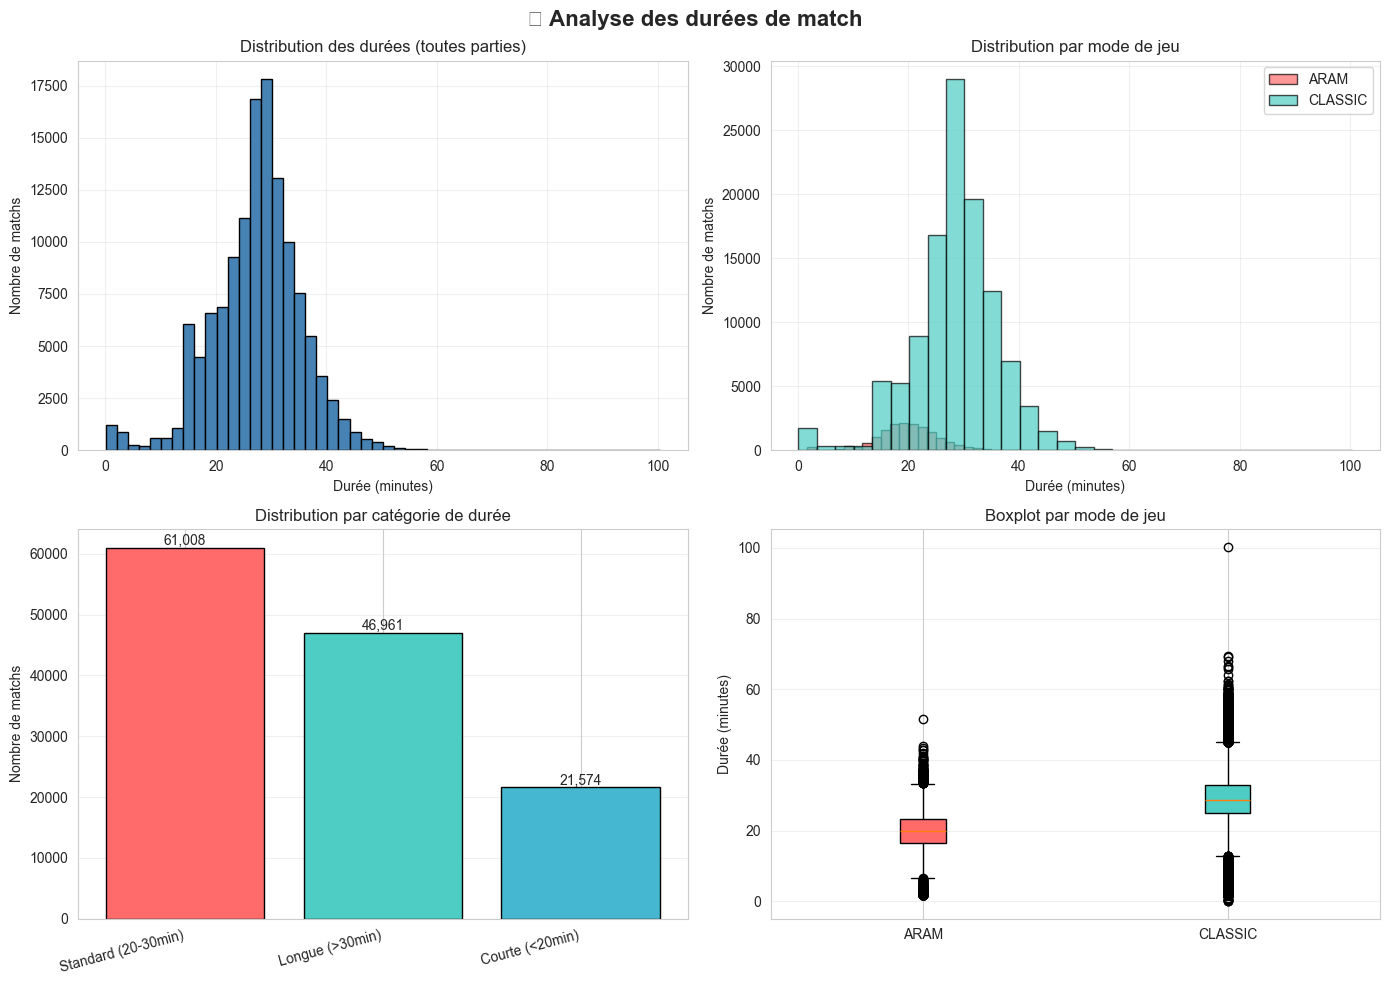


📈 Interprétation:
- ARAM: matchs plus courts (une seule lane, combats constants)
- CLASSIC: distribution plus étalée (stratégies variées)
- Pics autour de 15-20min (surrenders) et 25-35min (matchs complets)


In [38]:
# 1. Distribution des durées de match
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Analyse des durées de match', fontsize=16, fontweight='bold')

# Histogramme global
axes[0, 0].hist(matches_df['GameDuration']/60, bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Durée (minutes)')
axes[0, 0].set_ylabel('Nombre de matchs')
axes[0, 0].set_title('Distribution des durées (toutes parties)')
axes[0, 0].grid(alpha=0.3)

# Histogramme par mode
for mode, color in [('ARAM', '#FF6B6B'), ('CLASSIC', '#4ECDC4')]:
    mode_data = matches_df[matches_df['QueueType'] == mode]['GameDuration']/60
    axes[0, 1].hist(mode_data, bins=30, alpha=0.7, label=mode, color=color, edgecolor='black')
axes[0, 1].set_xlabel('Durée (minutes)')
axes[0, 1].set_ylabel('Nombre de matchs')
axes[0, 1].set_title('Distribution par mode de jeu')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Barplot des catégories
duration_counts = matches_df['DurationCategory'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = axes[1, 0].bar(range(len(duration_counts)), duration_counts.values, color=colors, edgecolor='black')
axes[1, 0].set_xticks(range(len(duration_counts)))
axes[1, 0].set_xticklabels(duration_counts.index, rotation=15, ha='right')
axes[1, 0].set_ylabel('Nombre de matchs')
axes[1, 0].set_title('Distribution par catégorie de durée')
axes[1, 0].grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom')

# Boxplot par mode
mode_data = [matches_df[matches_df['QueueType'] == mode]['GameDuration']/60 for mode in ['ARAM', 'CLASSIC']]
box = axes[1, 1].boxplot(mode_data, labels=['ARAM', 'CLASSIC'], patch_artist=True)
for patch, color in zip(box['boxes'], ['#FF6B6B', '#4ECDC4']):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Durée (minutes)')
axes[1, 1].set_title('Boxplot par mode de jeu')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print("- ARAM: matchs plus courts (une seule lane, combats constants)")
print("- CLASSIC: distribution plus étalée (stratégies variées)")
print("- Pics autour de 15-20min (surrenders) et 25-35min (matchs complets)")

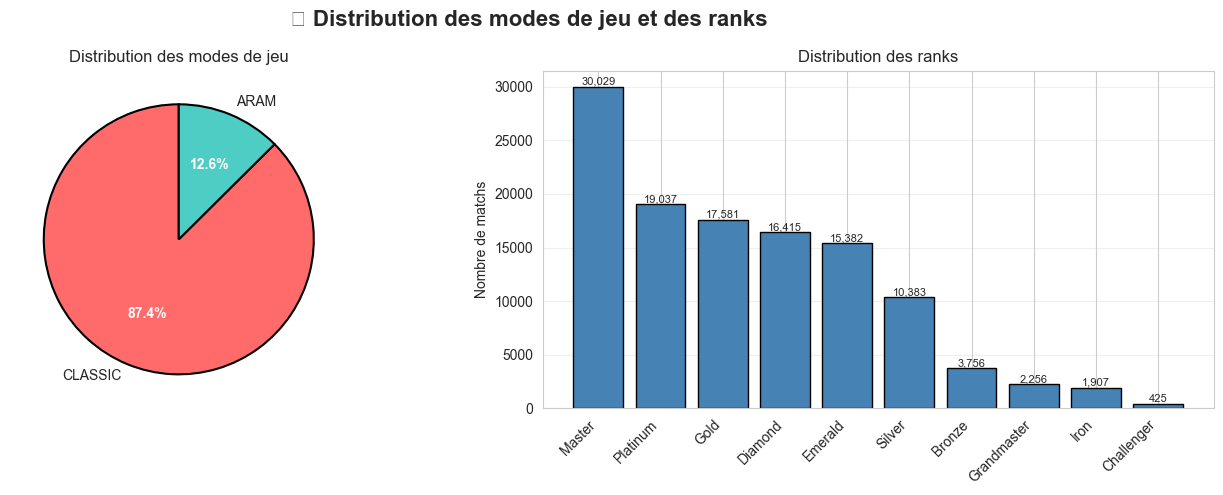


📈 Interprétation:
- Ratio ARAM/CLASSIC: 0.14
- Rank le plus représenté: Master
- Les rangs intermédiaires (Gold-Platinum) sont généralement les plus peuplés


In [39]:
# 2. Distribution des modes de jeu et ranks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('📊 Distribution des modes de jeu et des ranks', fontsize=16, fontweight='bold')

# Pie chart des modes
mode_counts = matches_df['QueueType'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = axes[0].pie(mode_counts.values, labels=mode_counts.index, 
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0].set_title('Distribution des modes de jeu')

# Barplot des ranks (pour ranked games uniquement)
if len(ranked_matches) > 0:
    rank_dist = ranked_matches.merge(ranks_df, left_on='RankFk', right_on='RankId')
    rank_counts = rank_dist['RankName'].value_counts()
    
    bars = axes[1].bar(range(len(rank_counts)), rank_counts.values, 
                       color='steelblue', edgecolor='black')
    axes[1].set_xticks(range(len(rank_counts)))
    axes[1].set_xticklabels(rank_counts.index, rotation=45, ha='right')
    axes[1].set_ylabel('Nombre de matchs')
    axes[1].set_title('Distribution des ranks')
    axes[1].grid(alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print(f"- Ratio ARAM/CLASSIC: {mode_counts['ARAM']/mode_counts['CLASSIC']:.2f}")

print(f"- Rank le plus représenté: {rank_counts.index[0] if len(ranked_matches) > 0 else 'N/A'}")
print("- Les rangs intermédiaires (Gold-Platinum) sont généralement les plus peuplés")

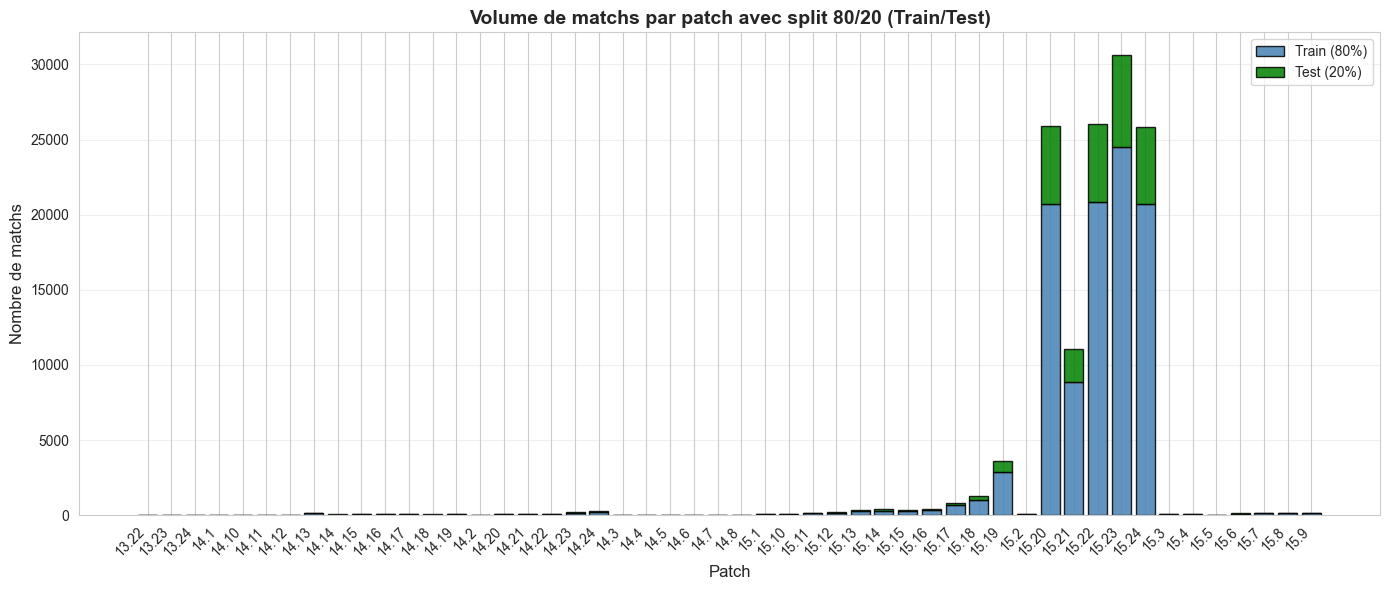


📈 Interprétation:
- Chaque patch est séparé en 80% Train / 20% Test (barres empilées)
- Le volume total varie selon les patches, mais la proportion est conservée
- On obtient une méta par patch sans mélange temporel


In [40]:
# 3. Évolution du nombre de matchs par patch (timeline) avec split 80/20
patch_timeline = pd.DataFrame(per_patch_stats).sort_values('PatchMajor')

fig, ax = plt.subplots(figsize=(14, 6))

# Barres empilées Train/Test par patch
ax.bar(patch_timeline['PatchMajor'], patch_timeline['train_count'],
       label='Train (80%)', color='steelblue', edgecolor='black', alpha=0.85)
ax.bar(patch_timeline['PatchMajor'], patch_timeline['test_count'],
       bottom=patch_timeline['train_count'], label='Test (20%)',
       color='green', edgecolor='black', alpha=0.85)

ax.set_xlabel('Patch', fontsize=12)
ax.set_ylabel('Nombre de matchs', fontsize=12)
ax.set_title('Volume de matchs par patch avec split 80/20 (Train/Test)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n📈 Interprétation:")
print("- Chaque patch est séparé en 80% Train / 20% Test (barres empilées)")
print("- Le volume total varie selon les patches, mais la proportion est conservée")
print("- On obtient une méta par patch sans mélange temporel")

## 0.8 - Sauvegarde des données nettoyées (optionnel)

**Objectif :** Sauvegarder les versions nettoyées pour réutilisation rapide.

**Avantages :**
- Éviter de refaire le nettoyage à chaque exécution
- Partager les données nettoyées avec l'équipe
- Garantir la cohérence entre les analyses

## 📋 Résumé de la Phase 0 - Bilan et prochaines étapes

### ✅ Ce qui a été accompli :

1. **Chargement des données** : 7 tables chargées (110K+ matchs, 223K+ enregistrements de stats)

2. **Exploration initiale** : 
   - Compréhension de la structure des données
   - Identification des types et dimensions
   - Détection des valeurs manquantes

3. **Nettoyage des anomalies** :
   - ChampionIds invalides supprimés de SummonerMatchTbl
   - Runes à 0 → NaN (données manquantes)
   - Sorts d'invocateur à 0 → NaN
   - Items invalides → NaN
   - Champions invalides supprimés de TeamMatchTbl

4. **Restriction des modes** :
   - Conservation des modes **CLASSIC** et **ARAM** uniquement (autres exclus)
   - Cascade du filtre aux tables de stats et équipes via MatchId

5. **Segmentation** :
   - Par mode de jeu (ARAM vs CLASSIC)
   - Par niveau de compétition (Ranked vs Unranked)
   - Par patch (analyse temporelle)
   - Par durée de partie (Courte/Standard/Longue)

6. **Split Train/Test par patch** :
   - Pour chaque patch, 80% des matchs en Train, 20% en Test
   - Méta évaluée séparément par patch, sans mélange temporel

7. **Visualisations** :
   - Distribution des durées de match
   - Répartition ARAM/CLASSIC
   - Distribution des ranks
   - Timeline des patches avec split 80/20 (Train/Test) empilé

### 🎯 Prochaines étapes :

**Phase I - Compréhension de la méta actuelle** :
- Analyse de l'efficacité des champions (winrate par rank, lane, durée)
- Analyse de l'impact des items (items core vs situationnels)

**Phase II - Optimisation du champion** :
- Identification des builds optimaux
- Analyse skill vs pick (performances mécaniques)

**Phase III - Draft et contre-stratégies** :
- Counter-picks
- Champions à bannir

**Phase IV - Stratégies globales de victoire** :
- Facteurs clés de victoire
- Prédiction de l'issue des parties

---

### 💾 Variables importantes créées :

```python
# Tables nettoyées
summoner_match_clean, match_stats_clean, team_match_clean

# Dataset filtré
matches_df (CLASSIC+ARAM uniquement)

# Segmentations
aram_matches, classic_matches
ranked_matches, unranked_matches

# Splits (80/20 par patch)
train_matches, test_matches
train_match_ids, test_match_ids
per_patch_stats

# Tables de référence
champions_df, items_df, ranks_df
```

# Phase I — Compréhension de la méta actuelle (ce qui gagne)

Objectif :
- Identifier les champions et items qui contribuent le plus aux victoires, par contexte (lane, rank, durée, patch)

## I.1 — Efficacité des champions

### Objectifs du pipeline d’analyse des champions

- Identifier automatiquement les colonnes clés dans toutes les tables de données.

- Normaliser et nettoyer les identifiants et les informations des matchs pour garantir la cohérence des données.

- Fusionner les données des matchs, des champions et des résultats pour créer un DataFrame unifié exploitable.

- Calculer les winrates globaux par champion et par lane afin d’évaluer leur performance.

- Visualiser de manière interactive les performances des champions pour faciliter l’exploration et l’analyse.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Robust helper: case-insensitive and fuzzy column finder
def find_col(df, candidates):
    cols = list(df.columns)
    # exact case-insensitive match
    for c in candidates:
        for col in cols:
            if col.lower() == c.lower():
                return col
    # contains (case-insensitive)
    for c in candidates:
        for col in cols:
            if c.lower() in col.lower():
                return col
    # fallback: any column that contains the word part (e.g., 'match' / 'champ')
    for c in candidates:
        tok = c.lower()
        for col in cols:
            if tok in col.lower():
                return col
    return None

def find_any_with_keyword(df, keyword):
    for col in df.columns:
        if keyword.lower() in col.lower():
            return col
    return None

def find_win_col(df):
    # prefer explicit 'Win' or common variants
    for c in ['Win', 'win', 'IsWin', 'iswin', 'Winner', 'winner', 'won', 'is_winner', 'iswinner']:
        if c in df.columns:
            return c
    # fallback: any column containing 'win'
    return find_any_with_keyword(df, 'win')

def report_col(logical_name, col, df_name, found, missing):
    if col is not None:
        found.append({
            'logical_name': logical_name,
            'column_name': col,
            'table': df_name
        })
    else:
        missing.append(logical_name)

def print_column_report(found, missing):
    print("\n" + "=" * 70)
    print("🔎 RAPPORT DE DÉTECTION DES COLONNES")
    print("=" * 70)

    if found:
        print("\n✅ Colonnes trouvées :")
        for f in found:
            print(f"  - {f['logical_name']:<22} → {f['column_name']}  (table: {f['table']})")

    if missing:
        print("\n❌ Colonnes NON trouvées :")
        for m in missing:
            print(f"  - {m}")

    if not missing:
        print("\n🎉 Toutes les colonnes attendues ont été trouvées.")

# ============================================================
# Select tables (use cleaned versions if present)
# ============================================================
ms = match_stats_clean if 'match_stats_clean' in globals() else match_stats_df
sm = summoner_match_clean if 'summoner_match_clean' in globals() else summoner_match_df
m  = matches_df

found_cols = []
missing_cols = []

# ============================================================
# Detect key columns more robustly
# ============================================================
# Match ID columns: try common names, then any 'match' containing column
ms_match_col = find_col(ms, ['MatchFk', 'MatchId', 'Match_Id', 'Match'])
sm_match_col = find_col(sm, ['MatchFk', 'MatchId', 'Match_Id', 'Match'])
m_id_col     = find_col(m,  ['MatchId', 'MatchFk', 'Match', 'Match_Id'])

report_col('ms_match_id', ms_match_col, 'match_stats', found_cols, missing_cols)
report_col('sm_match_id', sm_match_col, 'summoner_match', found_cols, missing_cols)
report_col('matches_id',  m_id_col,     'matches', found_cols, missing_cols)

# Champion columns
sm_champ_col = find_col(sm, ['ChampionFk', 'ChampionId', 'Champion', 'Champ'])
ms_champ_col = find_col(ms, ['ChampionFk', 'ChampionId', 'Champion', 'Champ'])

report_col('champion (summoner)', sm_champ_col, 'summoner_match', found_cols, missing_cols)
report_col('champion (stats)',    ms_champ_col, 'match_stats', found_cols, missing_cols)

champ_col = sm_champ_col or ms_champ_col

# Win column: search across ms / sm / m / team_match
win_col = find_win_col(ms) or find_win_col(sm) or find_win_col(m)
if win_col is None:
    tm = team_match_clean if 'team_match_clean' in globals() else team_match_df
    win_col = find_win_col(tm)
    report_col('win', win_col, 'team_match', found_cols, missing_cols)
else:
    origin = (
        'match_stats' if win_col in ms.columns else
        'summoner_match' if win_col in sm.columns else
        'matches'
    )
    report_col('win', win_col, origin, found_cols, missing_cols)

# Lane / Role
lane_col = (
    find_col(ms, ['Lane', 'Position', 'Role']) or
    find_col(sm, ['Lane', 'Position', 'Role'])
)
report_col('lane/role', lane_col, 'auto', found_cols, missing_cols)

# ============================================================
# Final report and guarded checks
# ============================================================
print_column_report(found_cols, missing_cols)

# Require: at least one match-id candidate across tables and champion (from summoner or stats) and win
if not (ms_match_col or sm_match_col or m_id_col):
    print("\n🚫 Aucun MatchId trouvé dans match_stats/summoner_match/matches — arrêt du pipeline")
    raise RuntimeError("Aucun MatchId trouvé dans les tables (match_stats/summoner_match/matches)")

if champ_col is None:
    print("\n🚫 Aucune colonne Champion trouvée (ni dans summoner_match ni dans match_stats) — arrêt du pipeline")
    raise RuntimeError("Colonnes Champion manquantes")

if win_col is None:
    print("\n🚫 Aucune colonne Win trouvée — arrêt du pipeline")
    raise RuntimeError("Colonne Win manquante")

print("\n▶️ Colonnes critiques présentes — exécution du pipeline...")

# ============================================================
# 🔧 NORMALISATION DES TYPES DE CLÉS (MATCH ID)
# ============================================================

def normalize_match_id(df, col):
    if col is None or col not in df.columns:
        return
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
    )

# Normaliser toutes les colonnes Match utilisées
normalize_match_id(sm, sm_match_col)
normalize_match_id(ms, ms_match_col)
normalize_match_id(m, m_id_col)

# team_match (si utilisé plus tard)
tm = None
if 'team_match_clean' in globals():
    tm = team_match_clean
elif 'team_match_df' in globals():
    tm = team_match_df

if tm is not None:
    tm_match_col = find_col(tm, ['MatchFk', 'MatchId'])
    normalize_match_id(tm, tm_match_col)

# ============================================================
# Construction de la table d'analyse (utilise summoner_match primary mapping)
# ============================================================
# ajouter lane_col si elle existe
cols_to_include = ['SummonerMatchId', sm_match_col, champ_col]
if lane_col and lane_col in sm.columns:
    cols_to_include.append(lane_col)

df = sm[cols_to_include].copy()

# Optionnel : ajouter ParticipantId si présent
if 'ParticipantId' in sm.columns:
    df['ParticipantId'] = sm['ParticipantId']

# merge matches metadata
df = df.merge(
    m[[m_id_col, 'RankFk', 'PatchMajor', 'GameDuration', 'QueueType']],
    left_on=sm_match_col,
    right_on=m_id_col,
    how='left'
)

# ============================================================
# 🔧 ALIGNEMENT DES TYPES POUR LE MERGE SUMMONER
# ============================================================

df['SummonerMatchId'] = df['SummonerMatchId'].astype(str)
ms['SummonerMatchFk'] = ms['SummonerMatchFk'].astype(str)


# ============================================================
# 🎯 MERGE WIN (SOURCE OFFICIELLE : MatchStatsTbl)
# ============================================================

df = df.merge(
    ms[['SummonerMatchFk', win_col]],
    left_on='SummonerMatchId',
    right_on='SummonerMatchFk',
    how='inner'   # chaque joueur DOIT avoir un Win
)

df = df.rename(columns={win_col: 'Win'})
df = df.drop(columns=['SummonerMatchFk'])


# ============================================================
# 🔧 NORMALISATION & NETTOYAGE DE LA COLONNE WIN
# ============================================================

if 'Win' in df.columns:
    # convertir bool / string → numeric
    df['Win'] = pd.to_numeric(df['Win'], errors='coerce')

    # diagnostic
    n_nan = df['Win'].isna().sum()
    if n_nan > 0:
        print(f"⚠️ {n_nan:,} lignes avec Win manquant → suppression")

    # supprimer lignes sans information de victoire
    df = df.dropna(subset=['Win'])

    # cast final en int (0 / 1)
    df['Win'] = df['Win'].astype(int)


if 'DurationCategory' not in df.columns:
    df['DurationCategory'] = pd.cut(
        df['GameDuration'] / 60,
        bins=[0, 20, 30, float('inf')],
        labels=['Courte', 'Standard', 'Longue']
    )

# ============================================================
# 📊 CALCUL DES WINRATES GLOBAL (avec noms de champions et lane)
# ============================================================

# Define the lane order
lane_order = ['NONE', 'SUPPORT', 'BOTTOM', 'MID', 'JUNGLE', 'TOP']

# Champion global
champ_wr = df.groupby('ChampionFk').agg(
    matches=('ChampionFk', 'size'),
    wins=('Win', 'sum')
)
champ_wr['winrate'] = champ_wr['wins'] / champ_wr['matches']

# Merge pour ajouter le nom et la lane du champion
if 'ChampionLane' not in champions_df.columns:
    champions_df['ChampionLane'] = 'NONE'

champ_wr = champ_wr.reset_index().merge(
    champions_df[['ChampionId', 'ChampionName', 'ChampionLane']],
    left_on='ChampionFk', right_on='ChampionId',
    how='left'
)

# garantir valeur par défaut cohérente et catégorie
champ_wr['ChampionLane'] = champ_wr['ChampionLane'].fillna('NONE').str.upper()
champ_wr['ChampionLane'] = pd.Categorical(
    champ_wr['ChampionLane'], categories=lane_order, ordered=True
)

# Tri : par lane puis par winrate décroissant
champ_wr = champ_wr.sort_values(['ChampionLane', 'winrate'], ascending=[True, False])

display(champ_wr[['ChampionName', 'ChampionLane', 'matches', 'wins', 'winrate']].head(20))

# ============================================================
# Scatter plot interactif avec tous les champions
# ============================================================
fig = px.scatter(
    champ_wr.sort_values('winrate', ascending=True),
    x='winrate',
    y='ChampionName',
    size='matches',
    color='winrate',
    hover_data=['matches', 'wins', 'ChampionLane'],
    color_continuous_scale='Viridis',
    size_max=40,
    title="Champions par Winrate [GLOBAL]"
)

fig.update_layout(
    xaxis_title="Winrate",
    yaxis_title="Champion",
    xaxis_range=[0,1],
    height=1200  # ajuste pour afficher tous les champions
)

fig.show()



🔎 RAPPORT DE DÉTECTION DES COLONNES

✅ Colonnes trouvées :
  - ms_match_id            → SummonerMatchFk  (table: match_stats)
  - sm_match_id            → MatchFk  (table: summoner_match)
  - matches_id             → MatchId  (table: matches)
  - champion (summoner)    → ChampionFk  (table: summoner_match)
  - champion (stats)       → EnemyChampionFk  (table: match_stats)
  - win                    → Win  (table: match_stats)
  - lane/role              → Lane  (table: auto)

🎉 Toutes les colonnes attendues ont été trouvées.

▶️ Colonnes critiques présentes — exécution du pipeline...


,ChampionName,ChampionLane,matches,wins,winrate
77,Leona,SUPPORT,1855,1022,0.550943
36,Sona,SUPPORT,1015,552,0.543842
153,Rell,SUPPORT,1146,621,0.541885
110,Zyra,SUPPORT,1242,672,0.541063
15,Soraka,SUPPORT,1287,690,0.536131
163,Renata,SUPPORT,749,388,0.518024
97,Lulu,SUPPORT,1945,1002,0.515167
116,Velkoz,SUPPORT,1657,852,0.514182
112,Seraphine,SUPPORT,1578,810,0.513308
168,Milio,SUPPORT,2055,1052,0.511922


In [44]:
# Filtrer uniquement les lanes valides (ignorer NONE)
valid_lanes = ['TOP', 'JUNGLE', 'MID', 'BOTTOM', 'SUPPORT']

for lane in valid_lanes:
    lane_df = champ_wr[champ_wr['ChampionLane'] == lane].copy()
    
    # Tri par winrate décroissant pour chaque lane
    lane_df = lane_df.sort_values('winrate', ascending=True)
    
    # -------------------
    # Graphique interactif
    # -------------------
    fig = px.scatter(
        lane_df,
        x='winrate',
        y='ChampionName',
        size='matches',
        color='winrate',
        hover_data=['matches', 'wins'],
        color_continuous_scale='Viridis',
        size_max=40,
        title=f"Winrate des champions — Lane {lane}"
    )
    
    fig.update_layout(
        xaxis_title="Winrate",
        yaxis_title="Champion",
        xaxis_range=[0,1],
        height=600
    )
    
    fig.show()
    
    # -------------------
    # Liste des champions avec winrate > 50%
    # -------------------
    top_champs = lane_df[lane_df['winrate'] > 0.5].sort_values('winrate', ascending=False)
    if not top_champs.empty:
        print(f"\n🏆 Champions avec >50% de winrate — Lane {lane} :")
        for i, row in top_champs.iterrows():
            print(f"  - {row['ChampionName']}: {row['winrate']:.2%} ({row['matches']} matchs)")
    else:
        print(f"\n🏆 Aucun champion avec >50% de winrate — Lane {lane}")



🏆 Champions avec >50% de winrate — Lane TOP :
  - Gnar: 55.19% (973 matchs)
  - Shen: 54.21% (1483 matchs)
  - Kled: 54.05% (655 matchs)
  - Jax: 53.86% (2412 matchs)
  - Mordekaiser: 53.78% (1588 matchs)
  - Yorick: 53.70% (946 matchs)
  - Sion: 53.17% (2005 matchs)
  - Kayle: 53.03% (1650 matchs)
  - DrMundo: 52.88% (2379 matchs)
  - Singed: 52.83% (829 matchs)
  - Heimerdinger: 52.62% (859 matchs)
  - Riven: 52.42% (1242 matchs)
  - Nasus: 52.07% (1089 matchs)
  - Garen: 51.87% (2113 matchs)
  - MonkeyKing: 51.74% (1177 matchs)
  - Malphite: 51.66% (2567 matchs)
  - Quinn: 51.60% (1029 matchs)
  - Tryndamere: 51.41% (743 matchs)
  - Ornn: 51.18% (1227 matchs)
  - Teemo: 50.75% (1330 matchs)
  - Renekton: 50.45% (1449 matchs)
  - Illaoi: 50.39% (766 matchs)
  - Poppy: 50.22% (1135 matchs)
  - Pantheon: 50.17% (1744 matchs)
  - Rumble: 50.13% (752 matchs)



🏆 Champions avec >50% de winrate — Lane JUNGLE :
  - Trundle: 54.85% (866 matchs)
  - Hecarim: 54.59% (883 matchs)
  - Fiddlesticks: 53.98% (1056 matchs)
  - Rammus: 53.60% (431 matchs)
  - Warwick: 53.39% (1326 matchs)
  - Amumu: 53.30% (1165 matchs)
  - Elise: 53.29% (835 matchs)
  - Belveth: 53.20% (562 matchs)
  - Nocturne: 52.82% (833 matchs)
  - Naafiri: 52.78% (1258 matchs)
  - Nunu: 52.73% (897 matchs)
  - Zaahen: 52.17% (2254 matchs)
  - Briar: 51.97% (1064 matchs)
  - Olaf: 51.88% (638 matchs)
  - Ivern: 51.60% (810 matchs)
  - Diana: 51.59% (2681 matchs)
  - Smolder: 51.36% (3059 matchs)
  - Nidalee: 51.04% (1299 matchs)
  - Khazix: 51.03% (1456 matchs)
  - Shaco: 50.85% (1764 matchs)
  - XinZhao: 50.66% (1358 matchs)
  - Udyr: 50.10% (970 matchs)
  - Kindred: 50.10% (982 matchs)



🏆 Champions avec >50% de winrate — Lane MID :
  - Lissandra: 57.81% (749 matchs)
  - Ahri: 55.85% (2342 matchs)
  - Malzahar: 53.15% (1680 matchs)
  - Swain: 53.08% (1718 matchs)
  - Corki: 52.98% (991 matchs)
  - Hwei: 52.73% (1756 matchs)
  - Syndra: 52.46% (2499 matchs)
  - Galio: 52.37% (1457 matchs)
  - Talon: 52.31% (1449 matchs)
  - Ryze: 52.21% (1199 matchs)
  - Aurora: 52.13% (1406 matchs)
  - Neeko: 51.49% (1274 matchs)
  - Brand: 51.05% (1473 matchs)
  - Zoe: 50.86% (1333 matchs)
  - Vex: 50.51% (782 matchs)
  - Veigar: 50.30% (1501 matchs)
  - Xerath: 50.29% (1754 matchs)
  - Yasuo: 50.27% (2562 matchs)
  - Viktor: 50.16% (1567 matchs)



🏆 Champions avec >50% de winrate — Lane BOTTOM :
  - Nilah: 55.74% (653 matchs)
  - Vayne: 55.30% (2530 matchs)
  - MissFortune: 54.79% (3984 matchs)
  - KogMaw: 53.83% (875 matchs)
  - Samira: 53.16% (1172 matchs)
  - Ashe: 52.81% (3439 matchs)
  - Tristana: 52.49% (2107 matchs)
  - Kalista: 51.72% (466 matchs)
  - Jhin: 51.15% (3517 matchs)
  - Jinx: 51.14% (3477 matchs)
  - Xayah: 50.94% (1280 matchs)
  - Draven: 50.78% (1349 matchs)
  - Kaisa: 50.59% (4669 matchs)



🏆 Champions avec >50% de winrate — Lane SUPPORT :
  - Leona: 55.09% (1855 matchs)
  - Sona: 54.38% (1015 matchs)
  - Rell: 54.19% (1146 matchs)
  - Zyra: 54.11% (1242 matchs)
  - Soraka: 53.61% (1287 matchs)
  - Renata: 51.80% (749 matchs)
  - Lulu: 51.52% (1945 matchs)
  - Velkoz: 51.42% (1657 matchs)
  - Seraphine: 51.33% (1578 matchs)
  - Milio: 51.19% (2055 matchs)
  - Rakan: 51.14% (1402 matchs)
  - Nautilus: 50.78% (2308 matchs)
  - Pyke: 50.61% (1569 matchs)
  - Senna: 50.60% (1666 matchs)
  - Nami: 50.46% (2806 matchs)
  - Braum: 50.39% (1155 matchs)
  - Morgana: 50.26% (2499 matchs)
  - Lux: 50.24% (2912 matchs)


In [49]:
# ============================================================
# Détection sur/sous-performance par Lane (triée)
# ============================================================
valid_lanes = ['TOP', 'JUNGLE', 'MID', 'BOTTOM', 'SUPPORT']

print("🔔 Sur- et sous-performers par lane :\n")
for lane in valid_lanes:
    lane_df = champ_wr[champ_wr['ChampionLane'] == lane].copy()
    
    if lane_df.empty:
        continue
    
    mean_wr = lane_df['winrate'].mean()
    std_wr  = lane_df['winrate'].std()
    
    # Sur-performers : tri décroissant par winrate
    sur_perf = lane_df[lane_df['winrate'] > mean_wr + std_wr].sort_values('winrate', ascending=False)
    # Sous-performers : tri croissant par winrate
    sous_perf = lane_df[lane_df['winrate'] < mean_wr - std_wr].sort_values('winrate', ascending=True)
    
    print(f"🏹 Lane {lane}:")
    
    if not sur_perf.empty:
        print("  🔝 Sur-performers :")
        for i, row in sur_perf.iterrows():
            print(f"    - {row['ChampionName']}: {row['winrate']:.2%} ({row['matches']} matchs)")
    else:
        print("  🔝 Aucun sur-performer")
    
    if not sous_perf.empty:
        print("  🔻 Sous-performers :")
        for i, row in sous_perf.iterrows():
            print(f"    - {row['ChampionName']}: {row['winrate']:.2%} ({row['matches']} matchs)")
    else:
        print("  🔻 Aucun sous-performer")
    
    print("\n")

# ============================================================
# Détection sur/sous-performance par Rank (triée)
# ============================================================
if 'RankFk' in df.columns:
    ranks = sorted(df['RankFk'].dropna().unique())
    print("🔔 Sur- et sous-performers par Rank :\n")
    for rank in ranks:
        rank_df = df[df['RankFk'] == rank].copy()
        if rank_df.empty:
            continue
        
        champ_rank_wr = rank_df.groupby('ChampionFk').agg(
            matches=('ChampionFk', 'size'),
            wins=('Win', 'sum')
        )
        champ_rank_wr['winrate'] = champ_rank_wr['wins'] / champ_rank_wr['matches']
        
        # Merge pour avoir le nom du champion
        champ_rank_wr = champ_rank_wr.reset_index().merge(
            champions_df[['ChampionId','ChampionName']],
            left_on='ChampionFk', right_on='ChampionId', how='left'
        )
        
        mean_wr = champ_rank_wr['winrate'].mean()
        std_wr  = champ_rank_wr['winrate'].std()
        
        sur_perf = champ_rank_wr[champ_rank_wr['winrate'] > mean_wr + std_wr].sort_values('winrate', ascending=False)
        sous_perf = champ_rank_wr[champ_rank_wr['winrate'] < mean_wr - std_wr].sort_values('winrate', ascending=True)
        
        print(f"🏅 Rank {rank}:")
        if not sur_perf.empty:
            print("  🔝 Sur-performers :")
            for i, row in sur_perf.iterrows():
                print(f"    - {row['ChampionName']}: {row['winrate']:.2%} ({row['matches']} matchs)")
        else:
            print("  🔝 Aucun sur-performer")
        
        if not sous_perf.empty:
            print("  🔻 Sous-performers :")
            for i, row in sous_perf.iterrows():
                print(f"    - {row['ChampionName']}: {row['winrate']:.2%} ({row['matches']} matchs)")
        else:
            print("  🔻 Aucun sous-performer")
        
        print("\n")


🔔 Sur- et sous-performers par lane :

🏹 Lane TOP:
  🔝 Sur-performers :
    - Gnar: 55.19% (973 matchs)
    - Shen: 54.21% (1483 matchs)
    - Kled: 54.05% (655 matchs)
    - Jax: 53.86% (2412 matchs)
    - Mordekaiser: 53.78% (1588 matchs)
    - Yorick: 53.70% (946 matchs)
    - Sion: 53.17% (2005 matchs)
  🔻 Sous-performers :
    - KSante: 43.63% (1130 matchs)
    - Aatrox: 47.40% (2038 matchs)
    - Kennen: 47.87% (704 matchs)
    - Jayce: 48.25% (1457 matchs)
    - Irelia: 48.38% (1480 matchs)


🏹 Lane JUNGLE:
  🔝 Sur-performers :
    - Trundle: 54.85% (866 matchs)
    - Hecarim: 54.59% (883 matchs)
    - Fiddlesticks: 53.98% (1056 matchs)
    - Rammus: 53.60% (431 matchs)
    - Warwick: 53.39% (1326 matchs)
    - Amumu: 53.30% (1165 matchs)
    - Elise: 53.29% (835 matchs)
    - Belveth: 53.20% (562 matchs)
  🔻 Sous-performers :
    - Skarner: 45.15% (423 matchs)
    - Shyvana: 46.10% (436 matchs)
    - Graves: 46.54% (1328 matchs)
    - MasterYi: 46.63% (1529 matchs)
    - Sejuani

## I.2 — Impact des items

DS — étapes :
- Fréquences items en victoire/défaite par lane; identifier items core (présents ≥ X% des builds gagnants d'un champion).

ML — étapes :
- Représentation items via multi-hot (top-k items), entraîner modèle items-only puis items+champion pour mesurer gain.

In [69]:
import pandas as pd
from collections import Counter

# -----------------------------
# 0️⃣ Mapping ItemID → ItemName
# -----------------------------
items_df['ItemID'] = items_df['ItemID'].astype(int)
itemid_to_name = dict(zip(items_df['ItemID'], items_df['ItemName']))

# -----------------------------
# 1️⃣ Copier table de travail
# -----------------------------
tmp = match_stats_clean.copy()

# Détecter colonne match pour merge
ms_match_col = next((c for c in tmp.columns if 'Match' in c), None)
sm_match_col = next((c for c in summoner_match_clean.columns if 'Match' in c), None)

# Forcer même type pour merge
if ms_match_col:
    tmp[ms_match_col] = tmp[ms_match_col].astype(str)
if sm_match_col:
    summoner_match_clean[sm_match_col] = summoner_match_clean[sm_match_col].astype(str)

# Assurer présence ChampionFk
if 'ChampionFk' not in tmp.columns:
    if 'ChampionFk' in summoner_match_clean.columns:
        tmp = tmp.merge(
            summoner_match_clean[[sm_match_col, 'ChampionFk']],
            left_on=ms_match_col,
            right_on=sm_match_col,
            how='left'
        )
    else:
        raise RuntimeError("Impossible de trouver 'ChampionFk' dans summoner_match_clean.")

tmp['ChampionFk'] = tmp['ChampionFk'].fillna(0).astype(int)

# -----------------------------
# 2️⃣ Détecter colonnes items (slots 1-6)
# -----------------------------
item_cols = [c for c in tmp.columns if c.lower().startswith('item')][:6]
if not item_cols:
    raise RuntimeError("Aucune colonne item détectée (item1..item6)")

# Remplacer IDs par noms
name_cols = []
for col in item_cols:
    name_col = f"{col}_name"
    tmp[name_col] = tmp[col].map(itemid_to_name).fillna('NONE').astype(str)
    name_cols.append(name_col)

# -----------------------------
# 3️⃣ Créer build_key et build_str
# -----------------------------
tmp['build_key'] = tmp[name_cols].apply(lambda r: tuple(sorted([i for i in r if i != 'NONE'])), axis=1)
tmp['build_str'] = tmp['build_key'].apply(lambda t: ' + '.join(t) if t else 'NO_ITEMS')

# -----------------------------
# 4️⃣ Agrégation par champion × item
# -----------------------------
champ_item_stats = []
for champ, df_champ in tmp.groupby('ChampionFk'):
    total_wins = df_champ['Win'].sum()
    item_counts = Counter()
    for items in df_champ[df_champ['Win']==1]['build_key']:
        item_counts.update(items)
    for item, count in item_counts.items():
        champ_item_stats.append({
            'ChampionFk': champ,
            'ItemName': item,
            'CountWins': count,
            'TotalWinsChampion': total_wins,
            'CoreItem': count / total_wins >= 0.5 if total_wins>0 else False
        })

champ_item_stats = pd.DataFrame(champ_item_stats)

# Ajouter noms des champions
champ_item_stats = champ_item_stats.merge(
    champions_df[['ChampionId','ChampionName']],
    left_on='ChampionFk', right_on='ChampionId',
    how='left'
).sort_values(['ChampionName','CoreItem'], ascending=[True, False])

# -----------------------------
# 5️⃣ Affichage final simple
# -----------------------------
for champ, df_c in champ_item_stats.groupby('ChampionName'):
    core_items = df_c[df_c['CoreItem']==True]['ItemName'].tolist()
    situational_items = df_c[df_c['CoreItem']==False]['ItemName'].tolist()
    print(f"\n🏹 {champ}")
    print(f"Core items    : {', '.join(core_items) if core_items else '—'}")
    print(f"Situationnels : {', '.join(situational_items) if situational_items else '—'}")



🏹 Aatrox
Core items    : Sundered Sky
Situationnels : Armored Advance, Doran's Blade, Long Sword, Serylda's Grudge, Spear of Shojin, Plated Steelcaps, The Brutalizer, Tiamat, Health Potion, Sterak's Gage, Caulfield's Warhammer, Ruby Crystal, Tunneler, Hubris, Mercury's Treads, Pickaxe, Control Ward, Last Whisper, Voltaic Cyclosword, Serrated Dirk, Edge of Night, Doran's Shield, Maw of Malmortius, Death's Dance, Thornmail, Chainlaced Crushers, Crimson Lucidity, Hexdrinker, Refillable Potion, Executioner's Calling, Glowing Mote, Boots, Spirit Visage, Serpent's Fang, Eclipse, Profane Hydra, Black Cleaver, Null-Magic Mantle, Guardian Angel, Cloth Armor, Guardian's Blade, Steel Sigil, Phage, Mortal Reminder, B. F. Sword, Warden's Mail, Stridebreaker, Overlord's Bloodmail, Hullbreaker, Ionian Boots of Lucidity, Chain Vest, Randuin's Omen, Cull, Kindlegem, Swiftmarch, Bramble Vest, Negatron Cloak, Guardian's Horn, Slightly Magical Footwear, Gustwalker Hatchling, Giant's Belt, Redemption, Che